In [1]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [3]:
data_dir = "/kaggle/input/flowers-five-classes/train"
dataset = datasets.ImageFolder(data_dir,transform=transform)

In [4]:
# Split the dataset into train and test sets
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_set, validation_set = random_split(dataset,[train_size,test_size])

In [5]:
len(train_set), len(validation_set)

(2196, 550)

In [6]:
# Create data loaders for train and validation sets
train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
validation_loader = DataLoader(validation_set,batch_size=32,shuffle=True)

In [7]:
for images, labels in train_loader:
    break

In [8]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

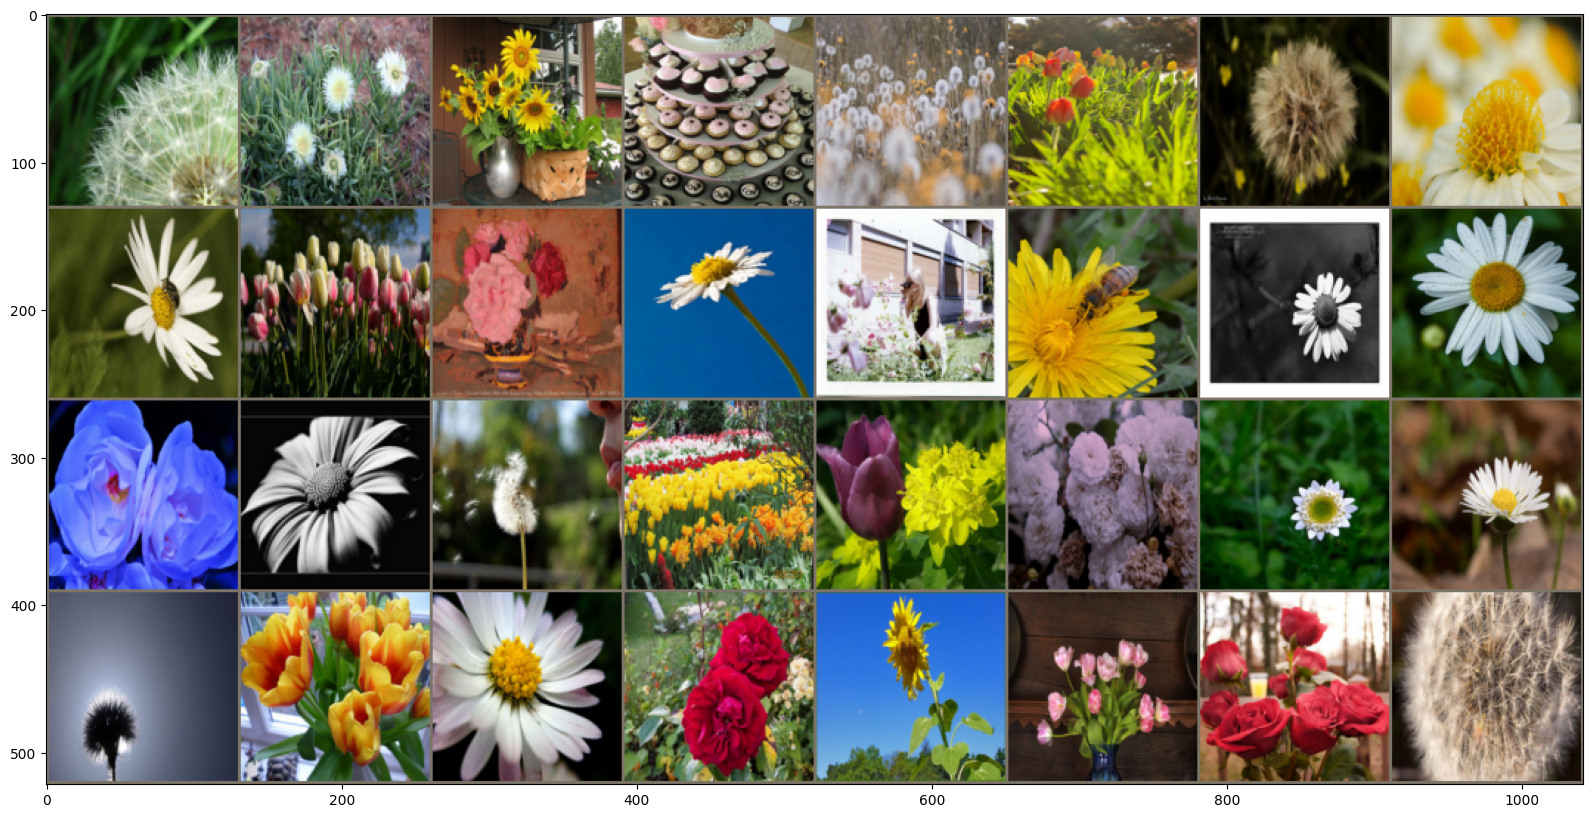

In [9]:
imgs = make_grid(images,nrow=8)
inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_images = inv_normalize(imgs)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(inv_images.numpy(),(1,2,0)));

In [10]:
((30-3+1)/1)/2

14.0

In [11]:
class ConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1) # 63,63,8
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=3,stride=1) # 30,30,32
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1) # 14,14,64
        self.fc1 = nn.Linear(14*14*64,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(in_features=32,out_features=5)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,14*14*64) # Flattening operation
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.4)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.3)
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [12]:
torch.manual_seed(42)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)

In [13]:
total_parameters = 0

for param in model.parameters():
    total_parameters += param.numel()
    
print("Total parameters of the CNN model:", total_parameters)

Total parameters of the CNN model: 826181


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [15]:
start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 20 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_val, y_val) in enumerate(validation_loader):
            y_pred = model(X_val)
            loss = criterion(y_pred,y_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
            
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())
    
print(f"Total time elapsed in CNN model training: {(time.time() - start_time)/60} minutes.")

Epoch 0 Batch 20 -> Loss: 1.5420159101486206
Epoch 0 Batch 40 -> Loss: 1.3849942684173584
Epoch 0 Batch 60 -> Loss: 1.3047949075698853
Epoch 1 Batch 20 -> Loss: 1.5276553630828857
Epoch 1 Batch 40 -> Loss: 1.3163120746612549
Epoch 1 Batch 60 -> Loss: 1.2679176330566406
Epoch 2 Batch 20 -> Loss: 1.0771677494049072
Epoch 2 Batch 40 -> Loss: 1.3186906576156616
Epoch 2 Batch 60 -> Loss: 1.2501834630966187
Epoch 3 Batch 20 -> Loss: 1.0507242679595947
Epoch 3 Batch 40 -> Loss: 0.9330865144729614
Epoch 3 Batch 60 -> Loss: 1.1440352201461792
Epoch 4 Batch 20 -> Loss: 0.9058552980422974
Epoch 4 Batch 40 -> Loss: 0.8921999335289001
Epoch 4 Batch 60 -> Loss: 0.9671130776405334
Epoch 5 Batch 20 -> Loss: 1.0934053659439087
Epoch 5 Batch 40 -> Loss: 1.0514519214630127
Epoch 5 Batch 60 -> Loss: 0.8581691980361938
Epoch 6 Batch 20 -> Loss: 0.7702251076698303
Epoch 6 Batch 40 -> Loss: 0.8306430578231812
Epoch 6 Batch 60 -> Loss: 1.0210978984832764
Epoch 7 Batch 20 -> Loss: 0.6779325604438782
Epoch 7 Ba

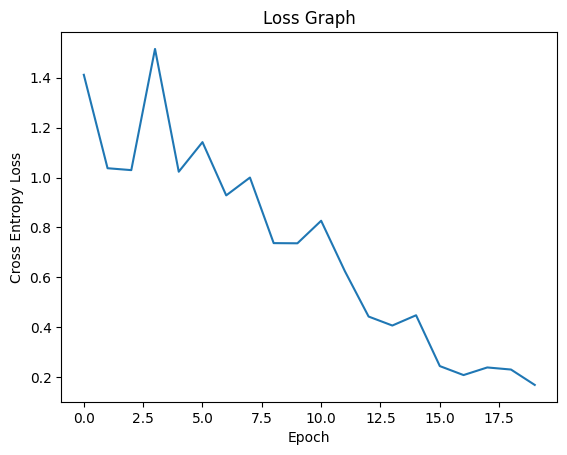

In [16]:
plt.plot(range(epochs),train_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

In [17]:
train_correct_predictions, val_correct_predictions

([657,
  973,
  1076,
  1150,
  1228,
  1341,
  1415,
  1480,
  1530,
  1603,
  1666,
  1725,
  1794,
  1855,
  1884,
  1892,
  1943,
  1957,
  1948,
  1990],
 [226,
  266,
  266,
  269,
  300,
  303,
  311,
  307,
  336,
  340,
  346,
  326,
  324,
  346,
  338,
  334,
  326,
  316,
  342,
  343])

In [18]:
train_accuracies = [x/2196 for x in train_correct_predictions]
val_accuracies = [x/550 for x in val_correct_predictions]

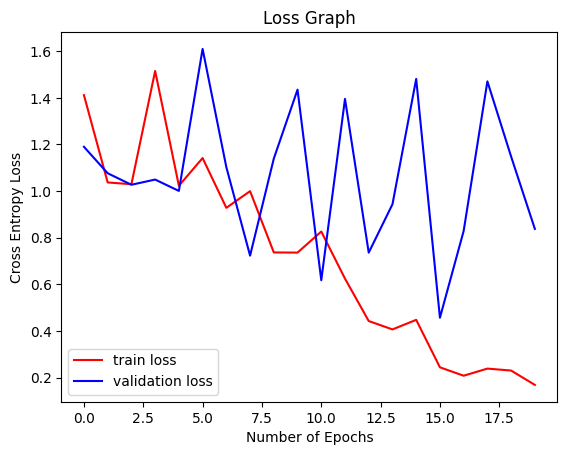

In [19]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

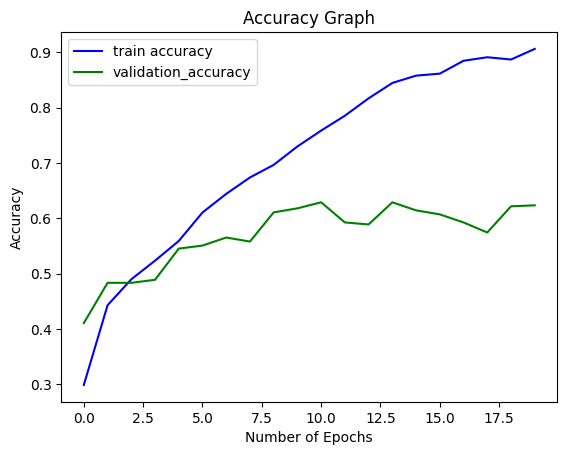

In [20]:
plt.plot(train_accuracies,'b',label='train accuracy')
plt.plot(val_accuracies,'g',label='validation_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [21]:
torch.save(model,'flowers_classifier.pt')

In [22]:
alexnet = models.alexnet(pretrained=True)
alexnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 65.1MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000


In [24]:
total_alexnet_params = 0

for param in alexnet.parameters():
    total_alexnet_params += param.numel()

print("Total parameters of the AlexNet model:", total_alexnet_params)

Total parameters of the AlexNet model: 61100840


In [25]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024,5),
    nn.LogSoftmax(dim=1)
)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet.classifier.parameters(),lr=0.001)

In [27]:
start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 20 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_val, y_val) in enumerate(validation_loader):
            y_pred = alexnet(X_val)
            loss = criterion(y_pred,y_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
            
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())
    
print(f"Total time elapsed in Alexnet model training: {(time.time() - start_time)/60} minutes.")

Epoch 0 Batch 20 -> Loss: 2.762028455734253
Epoch 0 Batch 40 -> Loss: 1.4191237688064575
Epoch 0 Batch 60 -> Loss: 1.791344165802002
Epoch 1 Batch 20 -> Loss: 0.37188977003097534
Epoch 1 Batch 40 -> Loss: 0.5922342538833618
Epoch 1 Batch 60 -> Loss: 0.31963399052619934
Epoch 2 Batch 20 -> Loss: 0.14844855666160583
Epoch 2 Batch 40 -> Loss: 0.6153160929679871
Epoch 2 Batch 60 -> Loss: 0.11665096133947372
Epoch 3 Batch 20 -> Loss: 0.1133183017373085
Epoch 3 Batch 40 -> Loss: 0.3636896312236786
Epoch 3 Batch 60 -> Loss: 0.36055031418800354
Epoch 4 Batch 20 -> Loss: 0.31514936685562134
Epoch 4 Batch 40 -> Loss: 0.553865909576416
Epoch 4 Batch 60 -> Loss: 0.013928880915045738
Epoch 5 Batch 20 -> Loss: 0.15402449667453766
Epoch 5 Batch 40 -> Loss: 0.05197636038064957
Epoch 5 Batch 60 -> Loss: 0.03375156968832016
Epoch 6 Batch 20 -> Loss: 0.1318637877702713
Epoch 6 Batch 40 -> Loss: 0.39281052350997925
Epoch 6 Batch 60 -> Loss: 0.3563706874847412
Epoch 7 Batch 20 -> Loss: 0.07502481341362
Epo

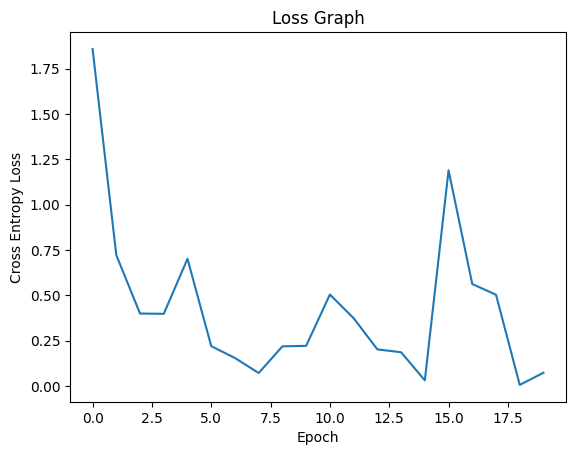

In [28]:
plt.plot(range(epochs),train_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

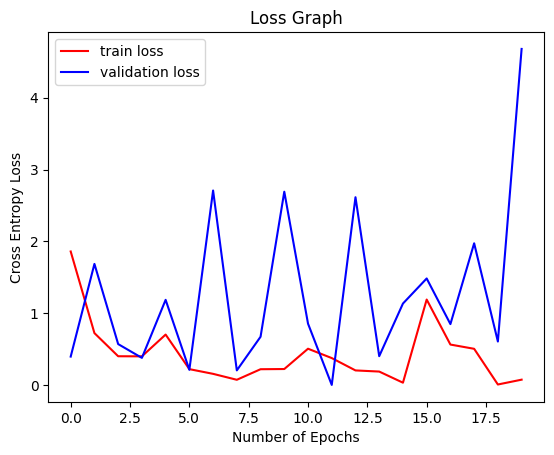

In [29]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [30]:
train_accuracies = [x/2196 for x in train_correct_predictions]
val_accuracies = [x/550 for x in val_correct_predictions]

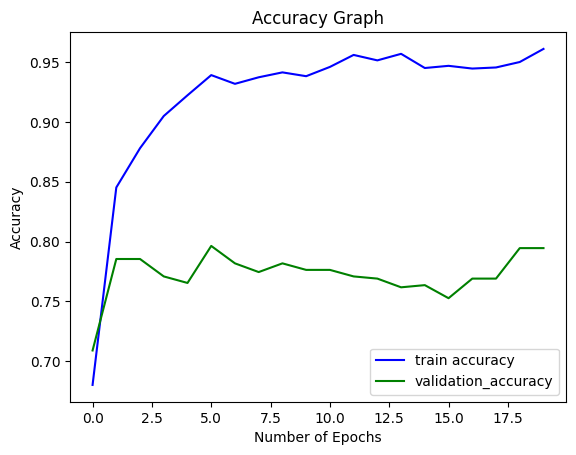

In [31]:
plt.plot(train_accuracies,'b',label='train accuracy')
plt.plot(val_accuracies,'g',label='validation_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [32]:
torch.save(alexnet,'flowers_alexnet_classifier.pt')

In [33]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000


In [35]:
total_vgg_params = 0

for param in vgg16.parameters():
    total_vgg_params += param.numel()

print("Total parameters of the VGG16 model:", total_vgg_params)

Total parameters of the VGG16 model: 138357544


In [36]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024,5),
    nn.LogSoftmax(dim=1)
)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16.classifier.parameters(),lr=0.001)

In [38]:
start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 20 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_val, y_val) in enumerate(validation_loader):
            y_pred = vgg16(X_val)
            loss = criterion(y_pred,y_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
            
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())
    
print(f"Total time elapsed in VGG16 model training: {(time.time() - start_time)/60} minutes.")

Epoch 0 Batch 20 -> Loss: 1.3239917755126953
Epoch 0 Batch 40 -> Loss: 0.6663808226585388
Epoch 0 Batch 60 -> Loss: 1.419201135635376
Epoch 1 Batch 20 -> Loss: 0.19335874915122986
Epoch 1 Batch 40 -> Loss: 0.553712785243988
Epoch 1 Batch 60 -> Loss: 0.07164162397384644
Epoch 2 Batch 20 -> Loss: 0.12482529878616333
Epoch 2 Batch 40 -> Loss: 0.07505568861961365
Epoch 2 Batch 60 -> Loss: 0.1908944845199585
Epoch 3 Batch 20 -> Loss: 0.3520696461200714
Epoch 3 Batch 40 -> Loss: 0.512556791305542
Epoch 3 Batch 60 -> Loss: 0.13558316230773926
Epoch 4 Batch 20 -> Loss: 0.16213679313659668
Epoch 4 Batch 40 -> Loss: 0.10617011785507202
Epoch 4 Batch 60 -> Loss: 0.15620066225528717
Epoch 5 Batch 20 -> Loss: 0.12035301327705383
Epoch 5 Batch 40 -> Loss: 0.02551894076168537
Epoch 5 Batch 60 -> Loss: 0.24245642125606537
Epoch 6 Batch 20 -> Loss: 0.06619060039520264
Epoch 6 Batch 40 -> Loss: 0.33346790075302124
Epoch 6 Batch 60 -> Loss: 0.39245888590812683
Epoch 7 Batch 20 -> Loss: 0.6712157130241394

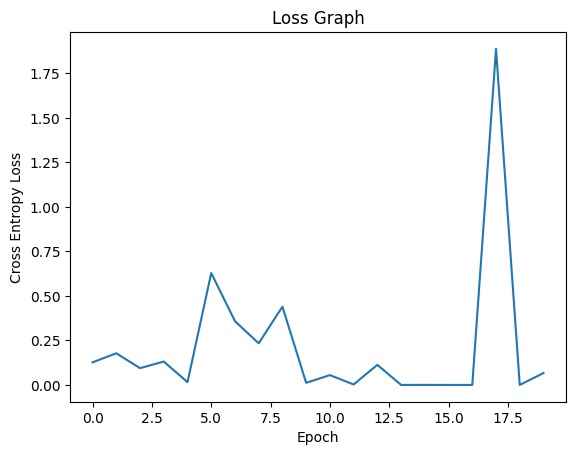

In [39]:
plt.plot(range(epochs),train_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

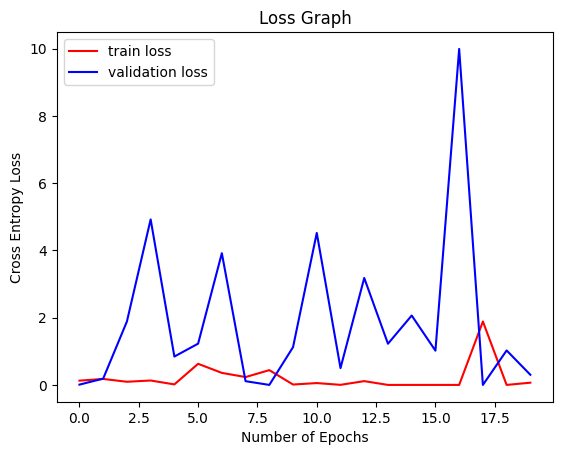

In [40]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [41]:
train_accuracies = [x/2196 for x in train_correct_predictions]
val_accuracies = [x/550 for x in val_correct_predictions]

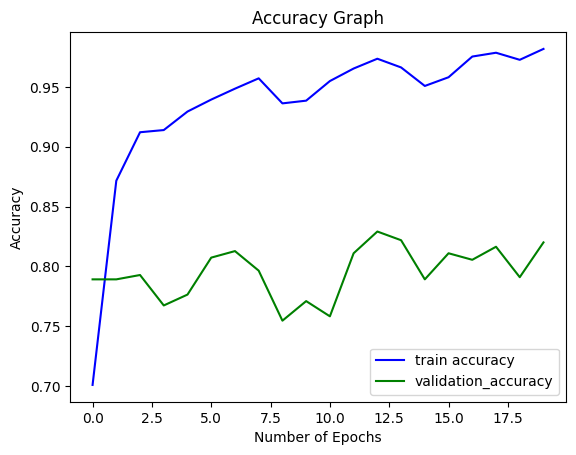

In [42]:
plt.plot(train_accuracies,'b',label='train accuracy')
plt.plot(val_accuracies,'g',label='validation_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [43]:
torch.save(vgg16,'flowers_vgg16_classifier.pt')

In [44]:
resnet50 = models.resnet50(pretrained=True)
resnet50

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
for param in resnet50.parameters():
    param.requires_grad = False
    print(param.numel())

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000


In [46]:
total_resnet_params = 0

for param in resnet50.parameters():
    total_resnet_params += param.numel()

print("Total parameters in the ResNet50 model:", total_resnet_params)

Total parameters in the ResNet50 model: 25557032


In [47]:
resnet50.fc = nn.Linear(in_features=2048,out_features=5)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.fc.parameters(),lr=0.001)

In [49]:
start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        y_pred = resnet50(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 20 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_val, y_val) in enumerate(validation_loader):
            y_pred = resnet50(X_val)
            loss = criterion(y_pred,y_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
            
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())
    
print(f"Total time elapsed in ResNet50 model training: {(time.time() - start_time)/60} minutes.")

Epoch 0 Batch 20 -> Loss: 1.0154672861099243
Epoch 0 Batch 40 -> Loss: 0.8236148357391357
Epoch 0 Batch 60 -> Loss: 0.6260701417922974
Epoch 1 Batch 20 -> Loss: 0.6405234336853027
Epoch 1 Batch 40 -> Loss: 0.4163050651550293
Epoch 1 Batch 60 -> Loss: 0.3902232348918915
Epoch 2 Batch 20 -> Loss: 0.521873950958252
Epoch 2 Batch 40 -> Loss: 0.5392457246780396
Epoch 2 Batch 60 -> Loss: 0.5680131316184998
Epoch 3 Batch 20 -> Loss: 0.31711459159851074
Epoch 3 Batch 40 -> Loss: 0.39665478467941284
Epoch 3 Batch 60 -> Loss: 0.4187895357608795
Epoch 4 Batch 20 -> Loss: 0.1957596242427826
Epoch 4 Batch 40 -> Loss: 0.31387627124786377
Epoch 4 Batch 60 -> Loss: 0.36298465728759766
Epoch 5 Batch 20 -> Loss: 0.3971709609031677
Epoch 5 Batch 40 -> Loss: 0.26048290729522705
Epoch 5 Batch 60 -> Loss: 0.47660031914711
Epoch 6 Batch 20 -> Loss: 0.3248509466648102
Epoch 6 Batch 40 -> Loss: 0.19217556715011597
Epoch 6 Batch 60 -> Loss: 0.3480640649795532
Epoch 7 Batch 20 -> Loss: 0.18203409016132355
Epoch 

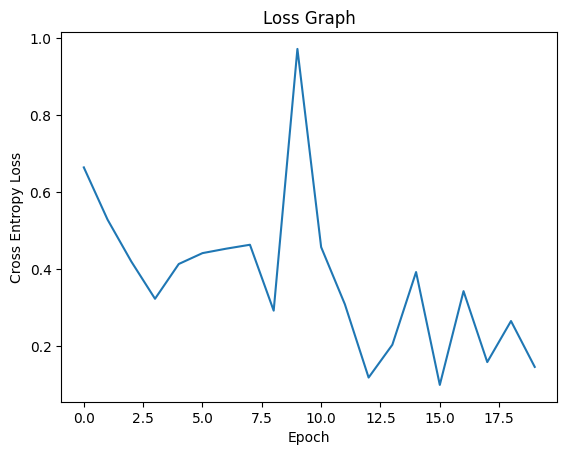

In [50]:
plt.plot(range(epochs),train_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

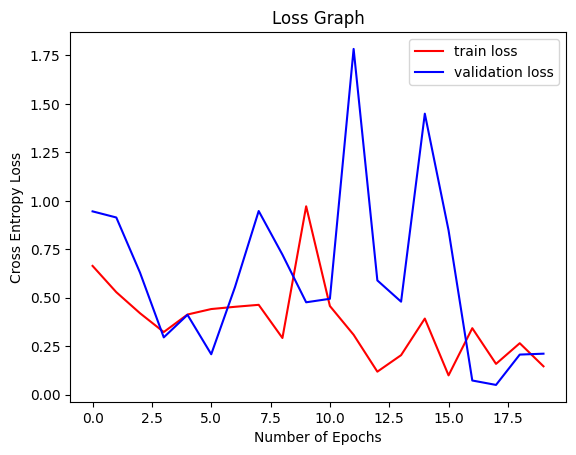

In [51]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [52]:
train_accuracies = [x/2196 for x in train_correct_predictions]
val_accuracies = [x/550 for x in val_correct_predictions]

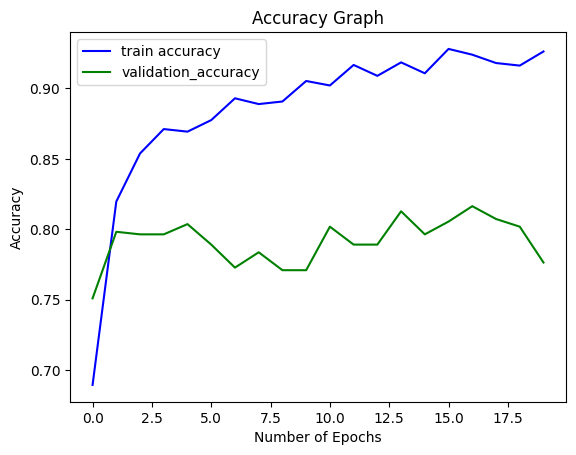

In [53]:
plt.plot(train_accuracies,'b',label='train accuracy')
plt.plot(val_accuracies,'g',label='validation_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [54]:
torch.save(resnet50,'flowers_resnet50_classifier.pt')

In [55]:
densenet121 = models.densenet121(pretrained=True)
densenet121

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 146MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [56]:
for param in densenet121.parameters():
    param.requires_grad = False
    print(param.numel())

9408
64
64
64
64
8192
128
128
36864
96
96
12288
128
128
36864
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
131072
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
65536
128
128
36864
544
544
69632
128
128
36864
576
576
73728
128
128
36864
608
608
77824
128
128
36864
640
640
81920
128
128
36864
672
672
86016
128
128
36864
704
704
90112
128
128
36864
736
736
94208
128
128
36864
768
768
98304

In [57]:
total_densenet_params = 0

for param in densenet121.parameters():
    total_densenet_params += param.numel()
    
print("Total parameters in the Densenet121 model:", total_densenet_params)

Total parameters in the Densenet121 model: 7978856


In [58]:
densenet121.classifier = nn.Linear(in_features=1024,out_features=5)
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=densenet121.classifier.parameters(),lr=0.001)

In [60]:
start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        y_pred = densenet121(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 20 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_val, y_val) in enumerate(validation_loader):
            y_pred = densenet121(X_val)
            loss = criterion(y_pred,y_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
            
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())
    
print(f"Total time elapsed in DenseNet121 model training: {(time.time() - start_time)/60} minutes.")

Epoch 0 Batch 20 -> Loss: 1.0623557567596436
Epoch 0 Batch 40 -> Loss: 0.8889884352684021
Epoch 0 Batch 60 -> Loss: 0.6728380918502808
Epoch 1 Batch 20 -> Loss: 0.5613625049591064
Epoch 1 Batch 40 -> Loss: 0.49536943435668945
Epoch 1 Batch 60 -> Loss: 0.5388804078102112
Epoch 2 Batch 20 -> Loss: 0.5184518098831177
Epoch 2 Batch 40 -> Loss: 0.34728866815567017
Epoch 2 Batch 60 -> Loss: 0.6755678057670593
Epoch 3 Batch 20 -> Loss: 0.6869248151779175
Epoch 3 Batch 40 -> Loss: 0.4159715473651886
Epoch 3 Batch 60 -> Loss: 0.5593538880348206
Epoch 4 Batch 20 -> Loss: 0.4270831346511841
Epoch 4 Batch 40 -> Loss: 0.4804689586162567
Epoch 4 Batch 60 -> Loss: 0.44154593348503113
Epoch 5 Batch 20 -> Loss: 0.4554075300693512
Epoch 5 Batch 40 -> Loss: 0.2180505245923996
Epoch 5 Batch 60 -> Loss: 0.28047916293144226
Epoch 6 Batch 20 -> Loss: 0.48322099447250366
Epoch 6 Batch 40 -> Loss: 0.24634070694446564
Epoch 6 Batch 60 -> Loss: 0.25236040353775024
Epoch 7 Batch 20 -> Loss: 0.35116517543792725
Ep

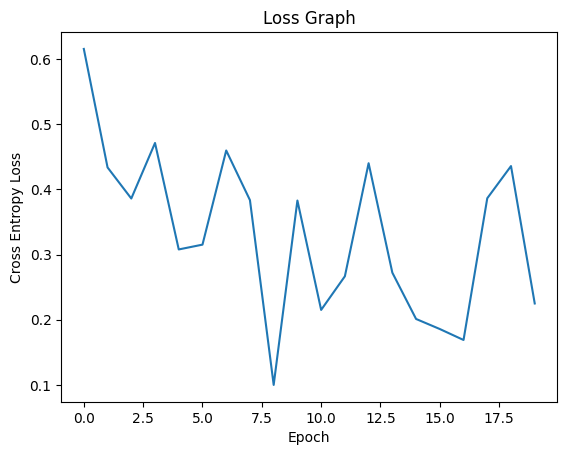

In [61]:
plt.plot(range(epochs),train_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

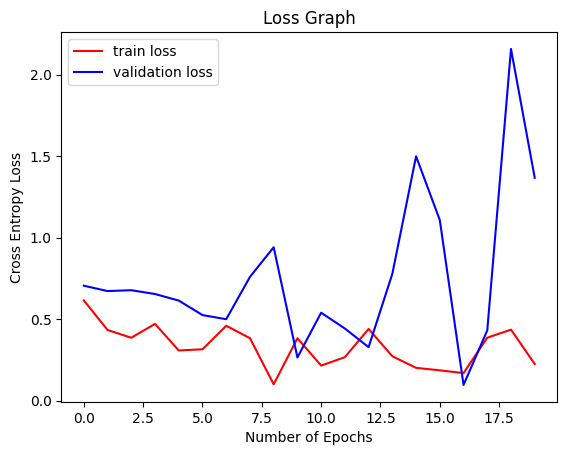

In [62]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [63]:
train_accuracies = [x/2196 for x in train_correct_predictions]
val_accuracies = [x/550 for x in val_correct_predictions]

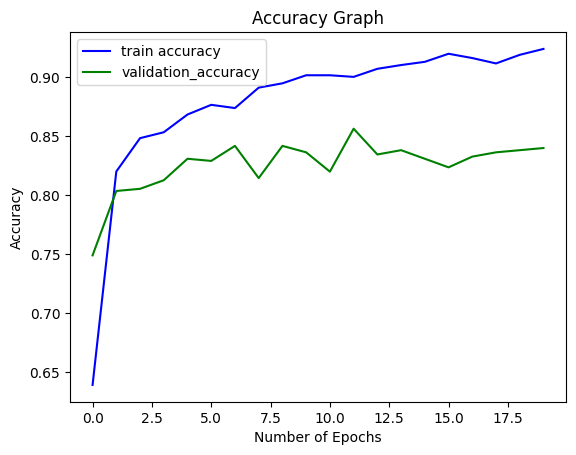

In [64]:
plt.plot(train_accuracies,'b',label='train accuracy')
plt.plot(val_accuracies,'g',label='validation_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [65]:
torch.save(densenet121,'flowers_densenet121_classifier.pt')